## Part1 Activation Function ELU

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (62.4 MB/s)
(Reading database ... 122518 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 122485 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.7

In [ ]:
import os
import pathlib
import librosa
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from sklearn.model_selection import train_test_split


In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'up' 'no' 'down' 'yes' 'left' 'go' 'stop']


In [ ]:
JSON_PATH = "data.json"
SAMPLES_TO_CONSIDER = 22050 # 1 sec. of audio

# dictionary where we'll store mapping, labels, MFCCs and filenames   
data = {
    "mapping": [],
    "labels": [],
    "MFCCs": [],
    "files": []
}

# loop through all sub-dirs
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):

    # ensure we're at sub-folder level
    if dirpath is not DATASET_PATH:

        # save label (i.e., sub-folder name) in the mapping
        label = dirpath.split("/")[-1]
        data["mapping"].append(label)
        print("\nProcessing: '{}'".format(label))

        # process all audio files in sub-dir and store MFCCs
        for f in filenames:
            file_path = os.path.join(dirpath, f)

            # load audio file and slice it to ensure length consistency among different files
            signal, sample_rate = librosa.load(file_path)

            # drop audio files with less than pre-decided number of samples
            if len(signal) >= SAMPLES_TO_CONSIDER:

                # ensure consistency of the length of the signal
                signal = signal[:SAMPLES_TO_CONSIDER]

                # extract MFCCs

                num_mfcc = 13
                n_fft = 2048
                hop_length = 512
                MFCCs = librosa.feature.mfcc(y=signal, n_mfcc=num_mfcc, hop_length=hop_length, n_fft=n_fft)
                # MFCCs = librosa.feature.mfcc(y=signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,hop_length=hop_length)

                # store data for analysed track
                data["MFCCs"].append(MFCCs.T.tolist())
                data["labels"].append(i-1)
                data["files"].append(file_path)
                print("{}: {}".format(file_path, i-1))

# save data in json file
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)


Streaming output truncated to the last 5000 lines.
data/mini_speech_commands/no/257251e0_nohash_0.wav: 2
data/mini_speech_commands/no/2bfe70ef_nohash_0.wav: 2
data/mini_speech_commands/no/9712cce0_nohash_0.wav: 2
data/mini_speech_commands/no/8830e17f_nohash_3.wav: 2
data/mini_speech_commands/no/6c0f6493_nohash_2.wav: 2
data/mini_speech_commands/no/079d1020_nohash_0.wav: 2
data/mini_speech_commands/no/5ff3f9a1_nohash_0.wav: 2
data/mini_speech_commands/no/270bfa52_nohash_0.wav: 2
data/mini_speech_commands/no/8dc26a15_nohash_0.wav: 2
data/mini_speech_commands/no/6736bc64_nohash_1.wav: 2
data/mini_speech_commands/no/4c432947_nohash_1.wav: 2
data/mini_speech_commands/no/421ed23f_nohash_0.wav: 2
data/mini_speech_commands/no/bc065a17_nohash_0.wav: 2
data/mini_speech_commands/no/6a014b29_nohash_0.wav: 2
data/mini_speech_commands/no/2bdbe5f7_nohash_3.wav: 2
data/mini_speech_commands/no/37e8db82_nohash_0.wav: 2
data/mini_speech_commands/no/ac652c60_nohash_0.wav: 2
data/mini_speech_commands/no/b8

In [ ]:
DATA_PATH = "data.json"

# generate train, validation and test sets        
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    # load dataset
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")


    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

Training sets loaded!


### Optimizer: Ada

In [ ]:
# create network

#parameters 
LEARNING_RATE = 0.001


def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='elu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimiser = tf.optimizers.Adamax(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 42, 11, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_1 (Batc  (None, 19, 4, 32)        128       
 hNormalization)                                                 
                                                        

In [ ]:
EPOCHS = 40
BATCH_SIZE = 16
PATIENCE = 5

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history




# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 14s 41ms/step - loss: 1.4512 - accuracy: 0.5136 - val_loss: 1.0232 - val_accuracy: 0.6876
Epoch 2/40
288/288 [==============================] - 14s 47ms/step - loss: 0.8482 - accuracy: 0.7437 - val_loss: 0.8070 - val_accuracy: 0.7589
Epoch 3/40
288/288 [==============================] - 12s 43ms/step - loss: 0.6469 - accuracy: 0.8158 - val_loss: 0.6526 - val_accuracy: 0.8068
Epoch 4/40
288/288 [==============================] - 12s 41ms/step - loss: 0.5460 - accuracy: 0.8478 - val_loss: 0.5636 - val_accuracy: 0.8416
Epoch 5/40
288/288 [==============================] - 10s 35ms/step - loss: 0.4722 - accuracy: 0.8663 - val_loss: 0.5410 - val_accuracy: 0.8451
Epoch 6/40
288/288 [==============================] - 9s 30ms/step - loss: 0.4186 - accuracy: 0.8944 - val_loss: 0.5273 - val_accuracy: 0.8442
Epoch 7/40
288/288 [==============================] - 10s 35ms/step - loss: 0.3831 - accuracy: 0.9022 - val_loss: 0.5126 - val_accuracy: 

In [ ]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))


45/45 [==============================] - 1s 15ms/step - loss: 0.4607 - accuracy: 0.8879

Test loss: 0.46074172854423523, test accuracy: 88.78830075263977


### Optiizer: *Adamax*

In [ ]:
# create network

#parameters 
LEARNING_RATE = 0.001


def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='elu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimiser = tf.optimizers.Adamax(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 42, 11, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_4 (Batc  (None, 19, 4, 32)        128       
 hNormalization)                                                 
                                                      

In [ ]:
EPOCHS = 40
BATCH_SIZE = 16
PATIENCE = 5

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history




# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 12s 35ms/step - loss: 1.3961 - accuracy: 0.5391 - val_loss: 1.0679 - val_accuracy: 0.6606
Epoch 2/40
288/288 [==============================] - 10s 35ms/step - loss: 0.8575 - accuracy: 0.7420 - val_loss: 0.8271 - val_accuracy: 0.7537
Epoch 3/40
288/288 [==============================] - 10s 35ms/step - loss: 0.6540 - accuracy: 0.8132 - val_loss: 0.7269 - val_accuracy: 0.7694
Epoch 4/40
288/288 [==============================] - 9s 30ms/step - loss: 0.5465 - accuracy: 0.8528 - val_loss: 0.6768 - val_accuracy: 0.8033
Epoch 5/40
288/288 [==============================] - 10s 35ms/step - loss: 0.4737 - accuracy: 0.8755 - val_loss: 0.5971 - val_accuracy: 0.8155
Epoch 6/40
288/288 [==============================] - 10s 35ms/step - loss: 0.4289 - accuracy: 0.8898 - val_loss: 0.5624 - val_accuracy: 0.8338
Epoch 7/40
288/288 [==============================] - 10s 34ms/step - loss: 0.4020 - accuracy: 0.8970 - val_loss: 0.5908 - val_accuracy: 

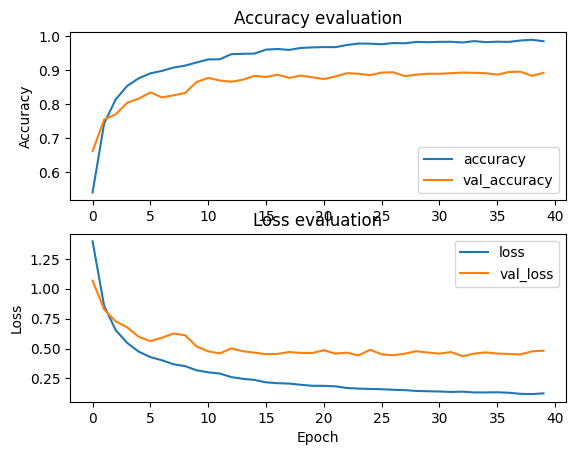

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()



# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

In [ ]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))


45/45 [==============================] - 1s 16ms/step - loss: 0.4190 - accuracy: 0.8983

Test loss: 0.4189881682395935, test accuracy: 89.83286619186401


### Optimizer: Adagrad

In [ ]:
# create network

#parameters 
LEARNING_RATE = 0.001


def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='elu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimiser = tf.optimizers.Adagrad(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 42, 11, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 21, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_7 (Batc  (None, 19, 4, 32)        128       
 hNormalization)                                                 
                                                      

In [ ]:
EPOCHS = 40
BATCH_SIZE = 16
PATIENCE = 5

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history




# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 11s 35ms/step - loss: 1.9166 - accuracy: 0.3433 - val_loss: 1.6296 - val_accuracy: 0.4526
Epoch 2/40
288/288 [==============================] - 10s 34ms/step - loss: 1.5143 - accuracy: 0.5003 - val_loss: 1.4427 - val_accuracy: 0.5265
Epoch 3/40
288/288 [==============================] - 10s 36ms/step - loss: 1.3698 - accuracy: 0.5578 - val_loss: 1.3386 - val_accuracy: 0.5631
Epoch 4/40
288/288 [==============================] - 9s 30ms/step - loss: 1.2714 - accuracy: 0.5987 - val_loss: 1.2604 - val_accuracy: 0.5849
Epoch 5/40
288/288 [==============================] - 10s 35ms/step - loss: 1.1976 - accuracy: 0.6190 - val_loss: 1.1992 - val_accuracy: 0.6144
Epoch 6/40
288/288 [==============================] - 10s 34ms/step - loss: 1.1309 - accuracy: 0.6506 - val_loss: 1.1413 - val_accuracy: 0.6336
Epoch 7/40
288/288 [==============================] - 10s 34ms/step - loss: 1.0812 - accuracy: 0.6684 - val_loss: 1.0908 - val_accuracy: 

In [ ]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))


45/45 [==============================] - 1s 18ms/step - loss: 0.6988 - accuracy: 0.7841

Test loss: 0.698760986328125, test accuracy: 78.41225862503052


### Optimizer:Nadam

In [ ]:
# create network

#parameters 
LEARNING_RATE = 0.001


def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='elu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimiser = tf.optimizers.Adagrad(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_9 (Batc  (None, 42, 11, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 21, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_10 (Bat  (None, 19, 4, 32)        128       
 chNormalization)                                                
                                                      

In [ ]:
EPOCHS = 40
BATCH_SIZE = 16
PATIENCE = 5

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history




# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 10s 31ms/step - loss: 1.9070 - accuracy: 0.3514 - val_loss: 1.6087 - val_accuracy: 0.4735
Epoch 2/40
288/288 [==============================] - 10s 34ms/step - loss: 1.4815 - accuracy: 0.5153 - val_loss: 1.3913 - val_accuracy: 0.5413
Epoch 3/40
288/288 [==============================] - 10s 34ms/step - loss: 1.3243 - accuracy: 0.5774 - val_loss: 1.2974 - val_accuracy: 0.5692
Epoch 4/40
288/288 [==============================] - 9s 31ms/step - loss: 1.2315 - accuracy: 0.6172 - val_loss: 1.2003 - val_accuracy: 0.6084
Epoch 5/40
288/288 [==============================] - 9s 32ms/step - loss: 1.1592 - accuracy: 0.6379 - val_loss: 1.1458 - val_accuracy: 0.6240
Epoch 6/40
288/288 [==============================] - 10s 35ms/step - loss: 1.0891 - accuracy: 0.6667 - val_loss: 1.0983 - val_accuracy: 0.6397
Epoch 7/40
288/288 [==============================] - 10s 34ms/step - loss: 1.0472 - accuracy: 0.6832 - val_loss: 1.0690 - val_accuracy: 0

In [ ]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))


45/45 [==============================] - 1s 17ms/step - loss: 0.7324 - accuracy: 0.7799

Test loss: 0.7324416041374207, test accuracy: 77.99443006515503


### Graphical Representation

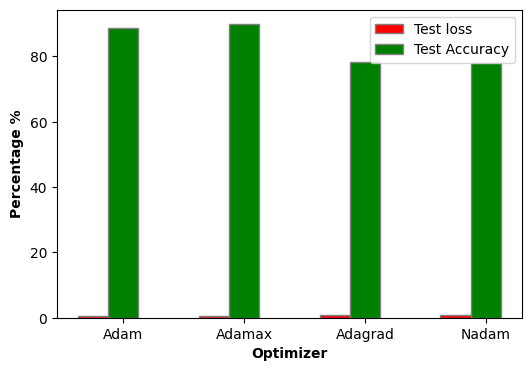

In [ ]:
#Plot 


import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 4))

# set height of bar
loss =  [0.4607, 0.418, 0.698, 0.732]
accuracy = [88.788, 89.832, 78.412, 77.998]


# Set position of bar on X axis
br1 = np.arange(len(loss))
br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, loss, color ='r', width = barWidth,
		edgecolor ='grey', label ='Test loss')
plt.bar(br2, accuracy, color ='g', width = barWidth,
		edgecolor ='grey', label ='Test Accuracy')
# plt.bar(br3, CSE, color ='b', width = barWidth,
# 		edgecolor ='grey', label ='CSE')

# Adding Xticks
plt.xlabel('Optimizer', fontweight ='bold', fontsize = 10)
plt.ylabel('Percentage %', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(len(loss))],
		['Adam', 'Adamax', 'Adagrad', 'Nadam'])

plt.legend()
plt.show()

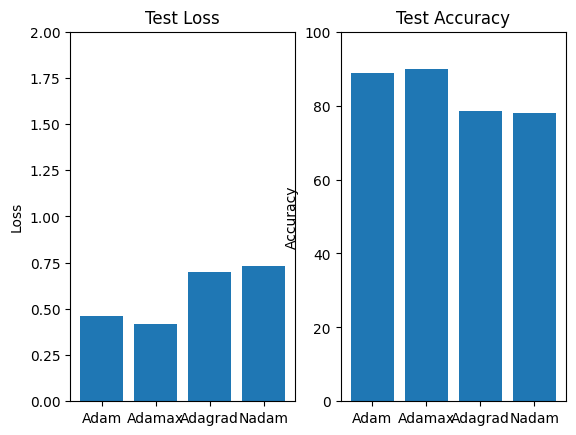

In [ ]:
import matplotlib.pyplot as plt

# Define the data
data = {
    'Adam': (0.4607, 88.788),
    'Adamax': (0.418, 89.832),
    'Adagrad': (0.698, 78.412),
    'Nadam': (0.732, 77.998)
}

# Create lists for the data
loss = [data[key][0] for key in data.keys()]
accuracy = [data[key][1] for key in data.keys()]

# Create a bar chart of the loss
plt.subplot(1, 2, 1)
plt.bar(data.keys(), loss)
plt.title('Test Loss')
plt.ylabel('Loss')
plt.ylim(0, 2)

# Create a bar chart of the accuracy
plt.subplot(1, 2, 2)
plt.bar(data.keys(), accuracy)
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 100)

# Display the plot
plt.show()
